In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets            # 取得圖片資料集
import torchvision.transforms as transforms # 圖片 transform
from models.AutoEncoder.AE import AutoEncoder
from utils.draw import showImg

import matplotlib.pyplot as plt
import numpy as np
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# 取得資料
temp_data = datasets.MNIST( './dataset', train=True, download=True, transform=transforms.ToTensor() )
temp_dataloader = DataLoader( temp_data, batch_size=10, shuffle=False)

torch.Size([10, 1, 28, 28])


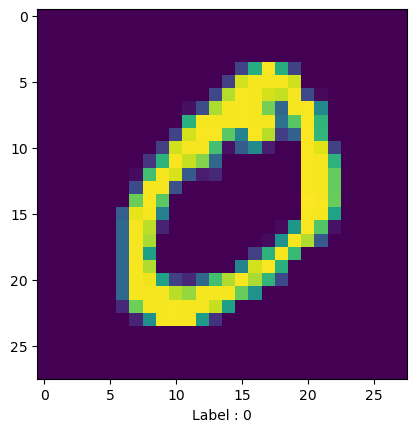

In [4]:
# 印出資料
for data, label in temp_dataloader:
    print(data.shape)
    plt.imshow(data[1,0,:,:])
    plt.xlabel( f"Label : {label[1].item()}" )
    plt.show()
    break

In [5]:
# 訓練資訊 & 超參數
epochs = 20
batch_size = 64
lr = 0.001
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

train_data = datasets.MNIST( './dataset', train=True, download=True, transform=transforms.ToTensor() )
train_dataloader = DataLoader( train_data, batch_size=batch_size, shuffle=True)


model = AutoEncoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=lr )

In [6]:
# Train
losses = []
for epoch in range(epochs):
    total_loss = 0
    for data, label in train_dataloader:
        x = data.view( -1, 28*28 ).to(device)   # 攤平圖片       
        
        embedding, output = model( x )
        loss = loss_fn( output, x )             #
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        losses.append( loss.item() )
        
    total_loss /= len(train_dataloader.dataset) # batch 平均 loss
    
    if(epoch % 5 == 0 ):
        print( f"Epoch: {epoch} / {epochs} \t Loss: {total_loss}")

Epoch: 0 / 20 	 Loss: 0.0008014080602675676
Epoch: 5 / 20 	 Loss: 0.0005987817134087284
Epoch: 10 / 20 	 Loss: 0.0005771692492067814
Epoch: 15 / 20 	 Loss: 0.0005595904973956446


In [7]:
# 印出 loss
# plt.plot( losses)
# plt.show()

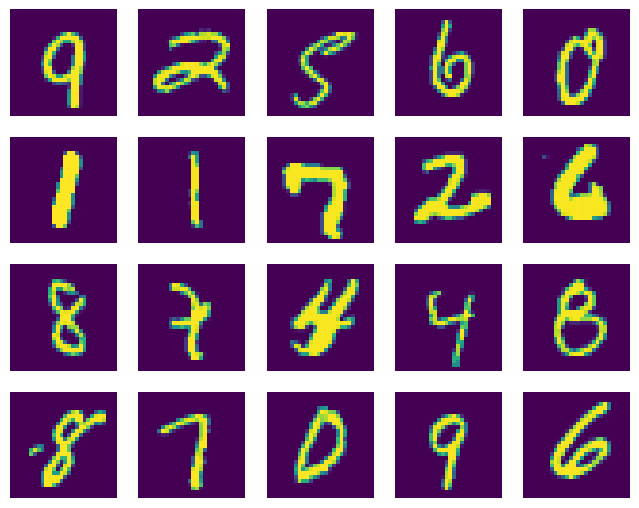

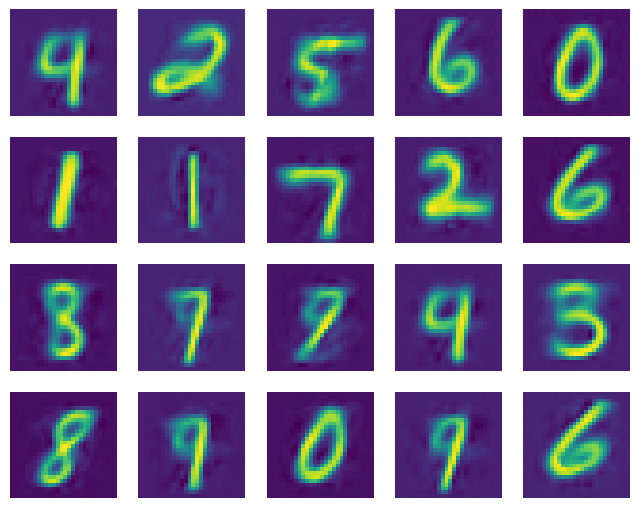

In [9]:
# 進行測試生成
test_data = datasets.MNIST( './dataset', train=False, download=True, transform=transforms.ToTensor() )
test_dataloader = DataLoader( test_data, batch_size=20, shuffle=True)

embedding_list = []
label_list = []

with torch.no_grad():
    for idx, ( data, label ) in enumerate( test_dataloader ):
        
        # 輸入圖片
        x = data.view( -1, 28*28 ).to(device)
        # AutoEncoder 生成
        embedding, output = model(x)
        
        # 印出圖片
        if( idx == 1 ):
            # 印出原圖片
            showImg( data )
            # 印出生成圖片
            showImg( output.cpu() )
            plt.show()
        
        # 儲存 embedding, label
        embedding_list.append(embedding.cpu().numpy())
        label_list.append(label.cpu().numpy())

(500, 20, 2)
(500, 20)


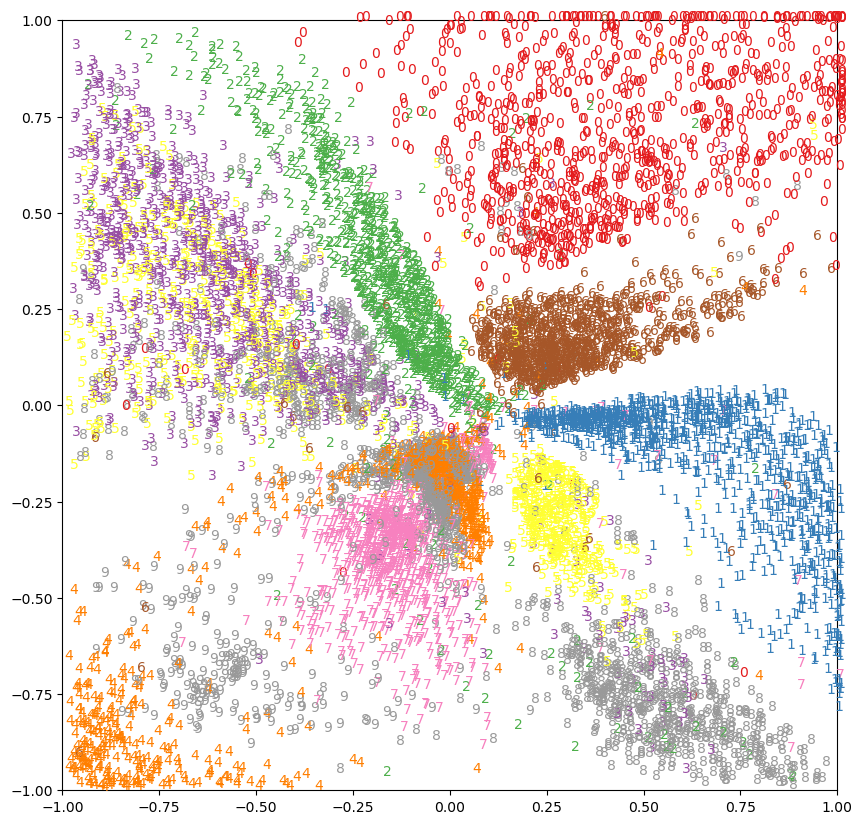

In [10]:
# Embedding 分布圖

embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
print(embedding_list.shape)
print(label_list.shape)

# 重塑 shape
embedding_list = embedding_list.reshape(500*20,2)
label_list = label_list.reshape(500*20)

# 印出
fig, ax = plt.subplots( figsize=(10,10) )
for i in range(label_list.shape[0]):
    color = plt.cm.Set1( label_list[i])     # 根據 label 來更換顏色
    ax.text( embedding_list[i,0], embedding_list[i,1], s=str(label_list[i]), color=color )  # 印出 text 點
    
plt.xlim(-1,1)  # 限制 x 軸大小
plt.ylim(-1,1)  # 限制 y 軸大小
plt.show()